In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from diffusers import (
    PNDMScheduler,
    DDIMScheduler,
    DDPMScheduler,
    DPMSolverMultistepScheduler,
    KDPM2DiscreteScheduler,
    DEISMultistepScheduler,

    
)

from pts.model.time_grad import TimeGradEstimator
from pts.dataset.repository.datasets import dataset_recipes

## Prepeare data set

In [3]:
dataset = get_dataset("solar_nips", regenerate=False)

In [4]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [5]:
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)

In [6]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [7]:
dataset.train

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7f208c0cbdc0>, iterable=JsonLinesFile(path=PosixPath('/home/bsj/.gluonts/datasets/solar_nips/train/data.json.gz'), start=0, n=None, line_starts=[0, 78839, 155505, 232170, 309139, 388420, 466339, 542525, 619700, 696925, 773605, 850245, 926308, 1003183, 1080623, 1157584, 1234651, 1311324, 1389024, 1466236, 1543438, 1620425, 1697192, 1775673, 1853734, 1930483, 2007750, 2084365, 2161083, 2239307, 2316606, 2394425, 2472610, 2550136, 2627358, 2703914, 2780095, 2857148, 2933693, 3010507, 3087758, 3165531, 3242261, 3319486, 3396402, 3475369, 3553239, 3630215, 3707249, 3783786, 3860987, 3938553, 4015620, 4092668, 4169390, 4245678, 4322796, 4400017, 4477199, 4554160, 4631519, 4707326, 4784654, 4861749, 4938819, 5015742, 5092323, 5169476, 5246983, 5324891, 5402539, 5479827, 5555367, 5632495, 5711086, 5788221, 5865273, 5941972, 6019492, 6096914, 6173863, 6251398, 6328834, 6405567, 6481841, 6559022, 6635850, 6712487, 6789547, 6865993, 6942

In [8]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

## Evaluator

In [9]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

## `TimeGrad`

In [10]:
scheduler = PNDMScheduler(
    num_train_timesteps=100,
    beta_end=0.2,
    beta_schedule="squaredcos_cap_v2",
)

In [11]:
scheduler = DDPMScheduler(
    num_train_timesteps=100,
    beta_end=0.1,
    beta_schedule="squaredcos_cap_v2",
    thresholding=True,
    clip_sample=False,
)

In [12]:
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)

In [13]:
estimator = TimeGradEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length * 3,
    freq=dataset.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=200, accelerator="gpu", devices="1"),
)

In [14]:
predictor = estimator.train(dataset_train, cache_data=True, shuffle_buffer_length=1024)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/bsj/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | In sizes                                                             | Out sizes        
---------------------------------------------------------------------------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.31578 (best 0.31578), saving model to '/home/bsj/workspace/pytorch-ts/examples/lightning_logs/version_26/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.11822 (best 0.11822), saving model to '/home/bsj/workspace/pytorch-ts/examples/lightning_logs/version_26/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.07816 (best 0.07816), saving model to '/home/bsj/workspace/pytorch-ts/examples/lightning_logs/version_26/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 0.06584 (best 0.06584), saving model to '/home/bsj/workspace/pytorch-ts/examples/lightning_logs/version_26/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 0.05932 (best 0.05932), saving model to '/home/bsj/workspace/pytorch-ts/examples/lightning_logs/version_26/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, glo

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 268.63it/s]
Running evaluation: 7it [00:00, 285.78it/s]
Running evaluation: 7it [00:00, 278.76it/s]
Running evaluation: 7it [00:00, 297.10it/s]
Running evaluation: 7it [00:00, 277.11it/s]
Running evaluation: 7it [00:00, 294.48it/s]
Running evaluation: 7it [00:00, 276.28it/s]
Running evaluation: 7it [00:00, 269.52it/s]
Running evaluation: 7it [00:00, 275.34it/s]
Running evaluation: 7it [00:00, 290.33it/s]
Running evaluation: 7it [00:00, 279.21it/s]
Running evaluation: 7it [00:00, 277.55it/s]
Running evaluation: 7it [00:00, 284.51it/s]
Running evaluation: 7it [00:00, 269.46it/s]
Running evaluation: 7it [00:00, 275.34it/s]
Running evaluation: 7it [00:00, 270.08it/s]
Running evaluation: 7it [00:00, 280.78it/s]
Running evaluation: 7it [00:00, 277.89it/s]
Running evaluation: 7it [00:00, 268.47it/s]
Running evaluation: 7it [00:00, 282.24it/s]
Running evaluation: 7it [00:00, 287.53it/s]
Running evaluation: 7it [00:00, 264.21it/s]
Running evaluation: 7it [00:00, 

### Metrics

In [ ]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 0.3807907532745109
ND: 0.47285042027956636
NRMSE: 0.9337866879641892
MSE: 827.1288023389459


In [ ]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS-Sum: 0.32428543791332215
ND-Sum: 0.38125915015659667
NRMSE-Sum: 0.6863502254449001
MSE-Sum: 8387074.571428572


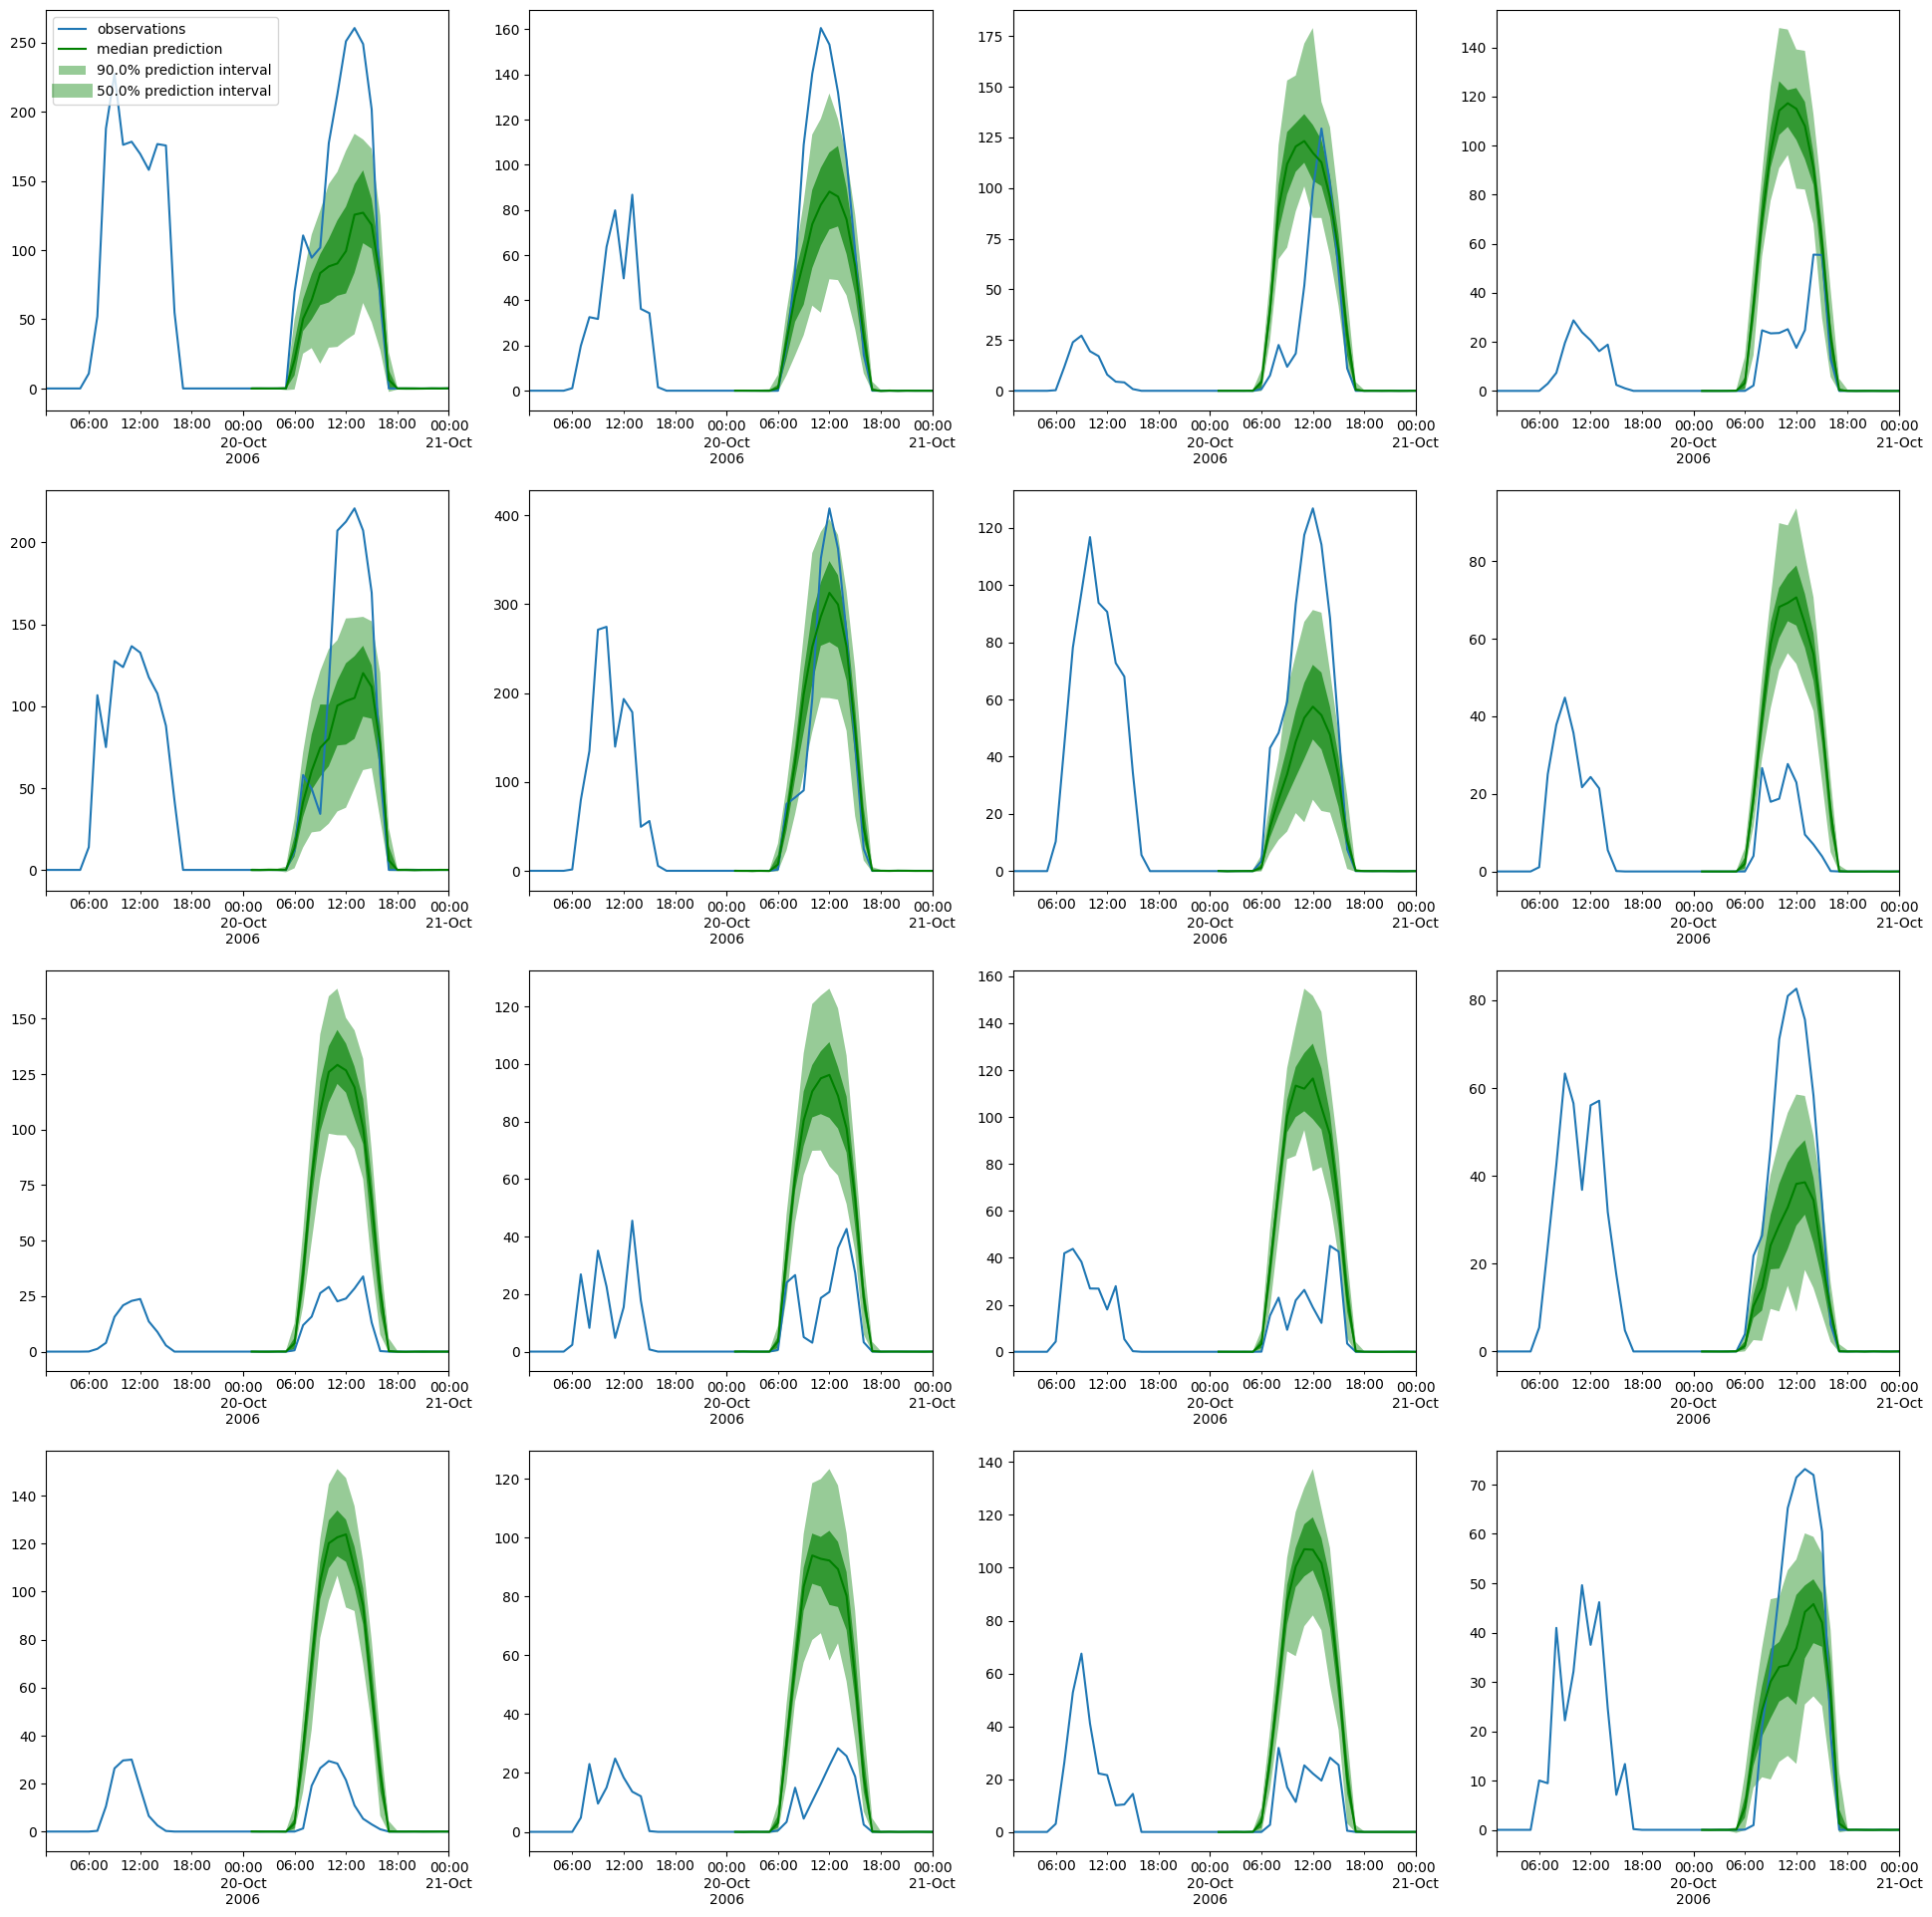

In [ ]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()